## data treatment

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [256]:
datas=np.load(r'\\data\OPENDATA\Instrumentation\Chirality\MChD\MChD-python\run30000.npz')
res=datas['res']
ttlin=datas['ttlin']
tstamps=datas['tstamps']

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [53]:
import h5py

class Measurement(object):
    
    def __init__(self):
        self.last_meas=0
        self.last_averaged=0
        
    
    def FromHdf5(self,fname):
        """
        load datas from h5 file inplace
        """
        f=h5py.File(fname, "r")
        datas=f['Scan']
        self.res=datas["Spectrums"]
        self.ttlin=datas["TTLinput"]
        self.tstamps=datas.attrs["Timestamps"]
        return self
    
    def FromNpz(self,fname):
        """
        load datas from npz file in memory
        """
        datas=np.load(fname)
        self.res=datas['res']
        self.ttlin=datas['ttlin']
        self.tstamps=datas['tstamps']
        return self

In [257]:
meas=Measurement().FromNpz(r'\\data\OPENDATA\Instrumentation\Chirality\MChD\MChD-python\run300-directHdf-5.npz')
meash5=Measurement().FromHdf5(r'\\data\OPENDATA\Instrumentation\Chirality\MChD\MChD-python\run300-directHdf-long.h5')

In [260]:
meash5.tstamps

array(["['2022-03-21T12:06:48.293101']", "['1970-01-01T00:00:00.000000']"],
      dtype=object)

In [259]:
duration=(meash5.tstamps[-1]-meash5.tstamps[0])[0]
duration/ np.timedelta64(1, 's')

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [261]:
meash5.ttlin,meas.ttlin

(<HDF5 dataset "TTLinput": shape (30000,), type "|i1">,
 array([2., 2., 2., ..., 0., 0., 0.]))

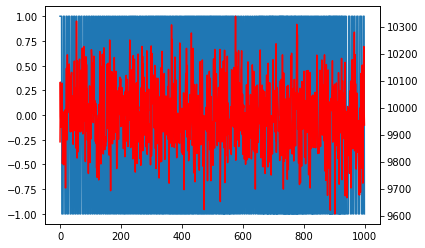

In [263]:

plot(meash5.ttlin[:1000]-1,'-')
plt.twinx()
plot(meash5.res[840,:1000],'r-')


842

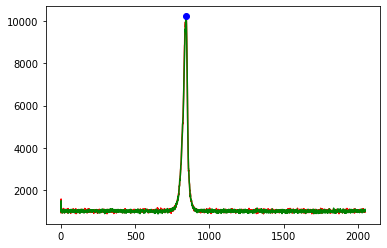

In [264]:
plot(meash5.res[:,0],'r')
plot(meas.res[:,0],'g')
plot(argmax(meas.res[:,0]),max(meas.res[:,0]),'bo')
argmax(meash5.res[:,0])

In [37]:
Fs=np.timedelta64(1, 's')/duration*meas.ttlin.shape[0]
Fs

34.52772880467029

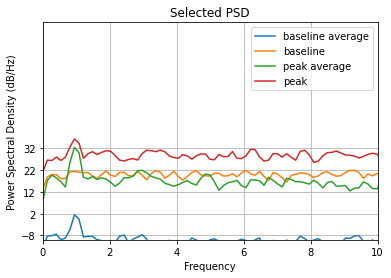

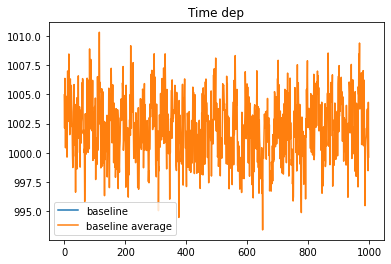

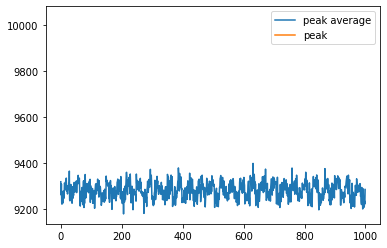

In [40]:
psd(1/2*(mean(meas.res[:500],axis=0) 
        # +        mean(res[2000:,:],axis=0)
        )
    ,Fs=Fs, label='baseline average', detrend='mean');
psd(mean(meas.res[0:1,:],axis=0),Fs=Fs, 
    label='baseline', detrend='mean');
psd(mean(meas.res[830:850,:],axis=0),Fs=Fs,
    label='peak average', detrend='mean');

psd(mean(meas.res[842:843,:],axis=0),Fs=Fs
    , detrend='mean',label='peak');
legend()
title('Selected PSD')
xlim(0,10)
ylim(-10,90)
figure()
title('Time dep')
plot(mean(meas.res[0,:1000],axis=0),label='baseline')
plot(mean(meas.res[0:600,:1000],axis=0),label='baseline average')
legend()
figure()
plot(mean(meas.res[830:850,:1000],axis=0),label='peak average')
plot(mean(meas.res[842,:1000],axis=0),label='peak')
legend()

In [43]:
%timeit mean(meas.res*(meas.ttlin-1),axis=1)

57.8 ms ± 7.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%timeit average(meas.res,weights=(meas.ttlin-1),axis=1)

The slowest run took 167.81 times longer than the fastest. This could mean that an intermediate result is being cached.
3.51 s ± 5.37 s per loop (mean ± std. dev. of 7 runs, 10 loops each)


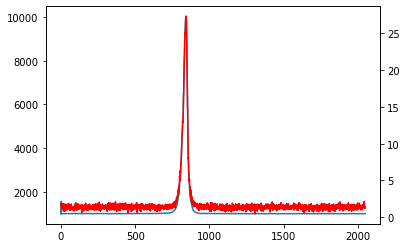

In [324]:
plot(mean(meas.res,axis=1))
twinx()
plot(average(meash5.res*(meash5.ttlin[:]-1),axis=1),'r')

(600.0, 1000.0)

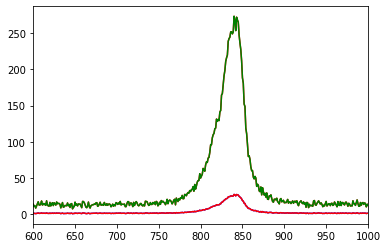

In [265]:
#check normalization difference beween mean and average
plot(mean(meash5.res*(meash5.ttlin[:]-1),axis=1),'b')
plot(mean(meash5.res*(meash5.ttlin[:]-1),axis=1,dtype='float64'),'r')
plot(1/3000*sum(meash5.res*(meash5.ttlin[:]-1),axis=1,dtype='float64'),'r')
plot(average(meash5.res,weights=(meash5.ttlin[:]-1),axis=1)/(3000/sum(meash5.ttlin[:]-1)),'g')
xlim(600,1000)

## chuncked calculation

0.0011737089201877935
-0.01643192488262911
-0.022300469483568074
-0.007042253521126761
0.002347417840375587
0.009389671361502348
0.0035211267605633804
0.01056338028169014
-0.01056338028169014
-0.007042253521126761
0.009389671361502348
0.0035211267605633804
0.0035211267605633804
-0.015258215962441314
0.022300469483568074
0.005868544600938967
0.011737089201877934
0.009389671361502348
-0.018779342723004695
0.017605633802816902
-0.008215962441314555
0.002347417840375587
-0.01995305164319249
0.012910798122065728
-0.007042253521126761
0.0
-0.005868544600938967
0.011737089201877934
-0.015258215962441314
-0.002347417840375587
-0.012910798122065728
0.007042253521126761
0.002347417840375587
0.028169014084507043
0.0


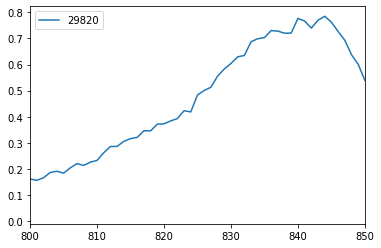

In [303]:
# non aligned chunks
chunked_mean=zeros(shape(meash5.res[:,0]))
k=int(8.53*100)
i,j=0,k
while j<size(meash5.ttlin):
    chunk_res=meash5.res[:,i:j]
    chunk_mod=meash5.ttlin[i:j]-1
    chunk_mean=mean(chunk_res*chunk_mod,axis=1)
    chunked_mean=i/j*chunked_mean+1/k*chunk_mean
    print(mean(chunk_mod))
    #plot(chunked_mean,label=i)
    i+=k
    j+=k


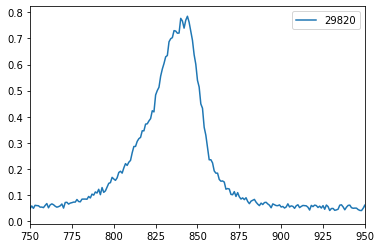

In [306]:
xlim(750,950)
plot(chunked_mean,label=i)
legend()

In [14]:
%timeit mean(chunk_res*chunk_mod,axis=1)

156 µs ± 3.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [143]:
size(meash5.ttlin)


3000

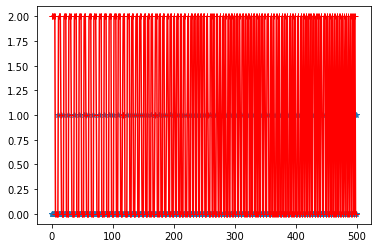

In [267]:
deriv=diff(meash5.ttlin)
edgesneg=((meash5.ttlin[1:]-1)>0)*deriv>0

plot(edgesneg[:500],'*')

plot(meash5.ttlin[:500],'r-+')

In [254]:
where(edgesneg)

(array([  11,   45,   78,  113,  148,  183,  214,  247,  282,  315,  349,
         381,  415,  450,  486,  520,  555,  586,  621,  655,  689,  724,
         757,  792,  828,  863,  898,  933,  966, 1001, 1036, 1072, 1100,
        1125, 1157, 1193, 1228, 1263, 1298, 1331, 1366, 1404, 1440, 1476,
        1509, 1541, 1578, 1615, 1651, 1687, 1721, 1751, 1789, 1825, 1862,
        1896, 1933, 1968, 2005, 2043, 2077, 2095, 2130, 2167, 2205, 2239,
        2272, 2309, 2346, 2383, 2421, 2456, 2493, 2531, 2568, 2606, 2640,
        2678, 2715, 2753, 2791, 2826, 2864, 2902, 2939, 2977], dtype=int64),)

In [326]:
chunked_mean=zeros(shape(meash5.res[:,0]))
chunked_mean2=zeros(shape(meash5.res[:,0]))
#edge detection
deriv=diff(meash5.ttlin)
edgesneg=((meash5.ttlin[1:]-1)<0)*deriv<0
edgeidx=where(edgesneg)[0]
k=0
m=100
histo=[]
while k <size(where(edgesneg))-m:
    i=edgeidx[k]
    j=edgeidx[k+m]
    k+=m
    chunk_res=meash5.res[:,i:j]
    chunk_mod=meash5.ttlin[i:j]-1
    possamples=where(chunk_mod>0)[0]
    negsamples=where(chunk_mod<0)[0]
    chunk_mean1=1/size(possamples)*sum(chunk_res[:,possamples],axis=1)
    chunk_mean2=-1/size(negsamples)*sum(chunk_res[:,negsamples],axis=1)
    chunk_mean3=mean(chunk_res[:,possamples],axis=1)-mean(chunk_res[:,negsamples],axis=1)
    chunk_mean=sum(chunk_res*chunk_mod,axis=1)                                                      
    chunked_mean2=i/j*chunked_mean2+1/j*(chunk_mean1+chunk_mean2)
    chunked_mean=i/j*chunked_mean+1/j*chunk_mean
    #print(i,j,j-i,mean(chunk_mod))
    #plot(chunked_mean,label=i)
    histo.append(chunked_mean)
#xlim(800,850)
#legend()
#semilogx(histo)


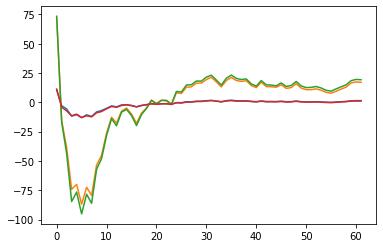

In [340]:
plot(transpose(array(histo))[500,:])
plot(transpose(array(histo))[850,:])
plot(transpose(array(histo))[830,:])
plot(transpose(array(histo))[2047,:])

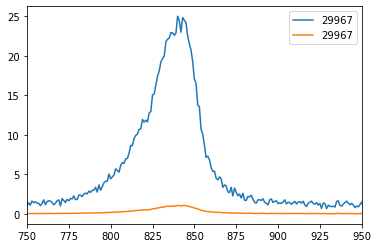

In [321]:
xlim(750,950)
plot(chunked_mean,label=i)
plot(chunked_mean2,label=i)
legend()

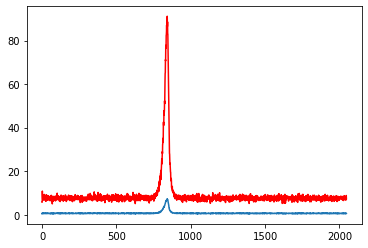

In [103]:
plot(chunked_mean)
plot(mean(meash5.res*(meash5.ttlin[:]-1),axis=1,dtype='float64'),'r')

In [345]:
datetime.datetime.now().timestamp()*1000*1000

1647881557799644.0